# OOD Robustness

## Preamble

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget
%load_ext dotenv
%dotenv

import os
import random
import pickle
from pathlib import Path
from itertools import repeat
import warnings

import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyprojroot
from IPython.display import display
from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score
from PIL import Image

root = pyprojroot.find_root(pyprojroot.has_dir(".git"))
os.chdir(root)

warnings.filterwarnings("ignore")
print(f"Current working directory: {Path.cwd()}")

from hyperpyper.utils import MultiFigurePlotter, MultiImagePlotter, PathList

from ood_robustness.utils.config import instantiate, parse_config, print_config
from ood_robustness.utils.random import seed_everything
from ood_robustness.utils.plotting import get_figsize, plot_pie_chart
from ood_robustness.utils.metrics import FPR95OODMetric

seed_everything(42)
plt.ioff()

Current working directory: /home/huberc/repos/ood/ood-robustness


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


In [3]:
OUTPUT_PATH = Path("./output")

NVERS = 5
shorts = ["EBO"] * NVERS + ["HB"] * NVERS + ["HB-Vit"] * NVERS + ["POEM"] * NVERS
models = [f.stem for f in sorted(OUTPUT_PATH.glob("*/"))]
models = dict(zip(models, shorts))

grouped_models = {n: [k for k, v in models.items() if v == n] for n in shorts[::NVERS]}

assert OUTPUT_PATH.exists()

## Definitions

In [4]:
def load_results(opath: Path, model: str, dataset: str, experiment: str):
    rpath = opath / model / dataset / experiment
    with (rpath / "output.pkl").open("rb") as ofile:
        output = pickle.load(ofile)

    cfg = parse_config(rpath / "cfg.yaml")
    return output, cfg

In [5]:
def get_normalizer(model):
    mID = torch.median(model.get_idd_reference_energy())
    mOOD = torch.median(model.get_ood_reference_energy())

    def norm(scores):
        return (scores - mID) / (mOOD - mID)

    return norm

In [6]:
METRICS = ["AUROC", "FPR95", "maxAE", "nMSE", "nWD"]


def compute_metrics_(model, energy, refs=None):
    norm = get_normalizer(model)

    energy = energy.ravel()
    idd_energy = model.get_idd_reference_energy(max_samples=len(energy)).ravel()
    ood_energy = model.get_ood_reference_energy(max_samples=len(energy)).ravel()

    if refs is None:
        refs = energy
    else:
        refs = refs.ravel()

    nidds = norm(idd_energy)
    noods = norm(ood_energy)
    nengs = norm(energy)
    nrefs = norm(refs)

    nmaxae = float(torch.abs(nengs - nrefs).max())
    nmse = float(((nengs - nrefs) ** 2).mean())

    max_wd = wasserstein_distance(idd_energy, ood_energy)
    wd = wasserstein_distance(idd_energy, energy)
    normed_wd = wd / max_wd

    labels = np.concatenate([np.zeros(len(idd_energy)), np.ones(len(energy))], axis=0)
    score = np.concatenate([idd_energy, energy], axis=0)

    auroc = roc_auc_score(labels, score)
    fpr95 = FPR95OODMetric()(-idd_energy, -energy)

    return dict(zip(METRICS, [auroc, fpr95, nmaxae, nmse, normed_wd]))


def compute_metrics(dataset, experiment, ref="Raw", idxs=None):
    data = dict(Model=[], Run=[], Experiment=[], **{m: [] for m in METRICS})
    for sname, versions in grouped_models.items():
        for i, model in enumerate(versions):
            out, cfg = load_results(OUTPUT_PATH, model, dataset, experiment)
            model = instantiate(cfg.model).create(device=DEVICE)

            r = out[ref]["item"]

            if idxs is not None:
                r = r[idxs]

            for name, exp in out.items():
                s = exp["item"]

                if idxs is not None:
                    s = s[idxs]

                data["Model"].append(sname)
                data["Run"].append(i)
                data["Experiment"].append(name if name != "Raw" else " Raw")
                for k, v in compute_metrics_(model, s, r).items():
                    data[k].append(v)

    return pd.DataFrame(data)

In [7]:
def plot_histogram(model, dsname, exp, bins=100, ax=None):
    scores = exp["item"].ravel()
    idd = model.get_idd_reference_energy(max_samples=len(scores))
    ood = model.get_ood_reference_energy(max_samples=len(scores))

    x = np.r_[scores, idd, ood]
    y = np.r_[[dsname] * len(scores), ["CIFAR10"] * len(idd), ["ImageNet"] * len(ood)]

    ax = sns.histplot(x=x, hue=y, bins=bins, alpha=0.7, legend=True, ax=ax)

    ax.set_yscale("log")
    ax.get_figure().legend()
    return ax

In [8]:
def to_images(tensors):
    imgs = []
    for t in tensors:
        t = t.moveaxis(0, -1)
        t = np.uint8(tt.numpy() * 255)
        imgs.append(Image.fromarray(t))
    return imgs


def plot_samples(*rows):
    nrows = len(rows)
    ncols = len(rows[0])

    return MultiImagePlotter(
        sum(rows, []), layout=(nrows, ncols), figsize=(8, 5)
    ).plot()

In [9]:
def plot_results(results, xlabel, xticks):
    fig, axes = plt.subplots(
        ncols=len(METRICS),
        figsize=get_figsize(12, aspect_ratio=1 / len(METRICS), scale=1.6),
    )
    for m, ax in zip(METRICS, axes.flatten()):
        sns.lineplot(
            data=results,
            x="Experiment",
            y=m,
            hue="Model",
            errorbar=("ci", 95),
            err_kws={"alpha": 0.35},
            ax=ax,
        )
        ax.set_xlabel(xlabel)
        ax.set_xticks(
            range(len(xticks)),
            xticks,
            rotation=60,
        )
        hl = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.tight_layout()
    fig.legend(
        *ax.get_legend_handles_labels(),
        loc="upper center",
        ncols=4,
        bbox_to_anchor=(0.5, 1.07),
    )
    return fig

In [10]:
def read_csv_data_frames(file_names):
    data_frames = []

    for file_name in file_names:
        data_frames.append(pd.read_csv(file_name))

    return pd.concat(data_frames)


def group_idx(files, meta, name):
    meta["fname"] = meta["plot_function"] + "/" + meta["file_name"]
    df = meta.set_index("fname")[name]

    results = {k: list() for k in meta_df[name].unique()}
    for i, f in enumerate(files):
        angle = df.loc[f]
        results[angle].append(i)

    return results


def group_scores(scores, group_indices):
    result = []
    scores = np.asarray(scores)
    for _, indices in sorted(group_indices):
        result.append(scores[np.asarray(indices)])

    return result

## Resize

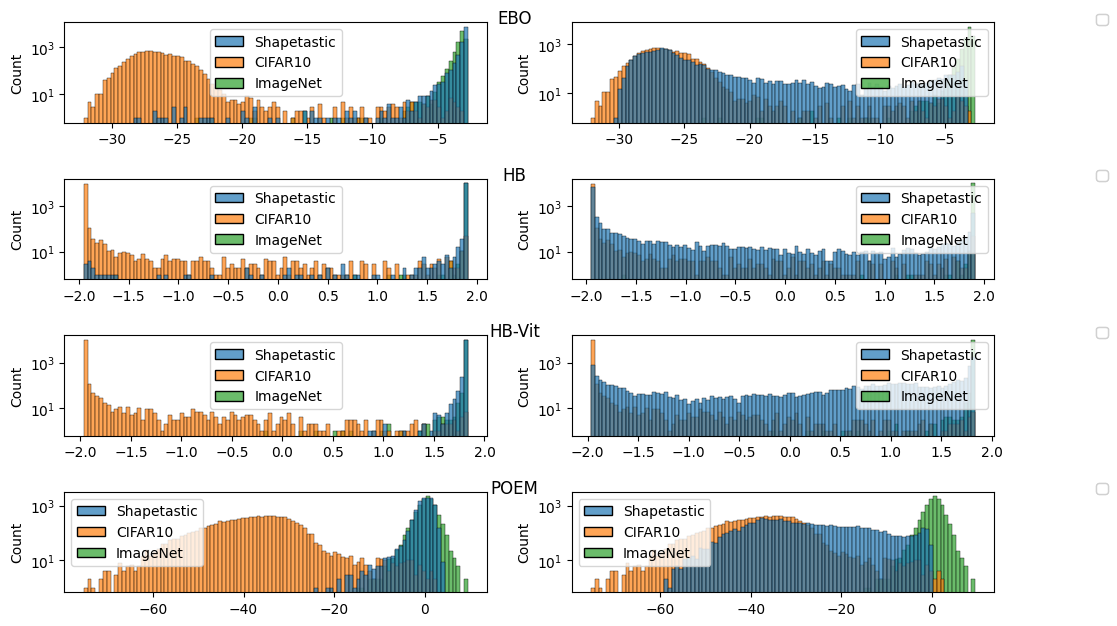

In [11]:
hist_plots = plt.figure(figsize=get_figsize(12, aspect_ratio=1 / 2)).subfigures(
    nrows=4, wspace=0
)
for (mname, m), sfig in zip(grouped_models.items(), hist_plots):
    ax1, ax2 = sfig.subplots(ncols=2)
    sfig.suptitle(mname)

    out1, cfg1 = load_results(OUTPUT_PATH, m[0], "shapetastic_ni_32", "no_transform")
    out2, cfg2 = load_results(OUTPUT_PATH, m[0], "shapetastic_ni_64", "no_transform")

    model = instantiate(cfg1.model).create(device=DEVICE)

    samples32 = out1["Raw"]["transformed_image"]
    samples64 = out2["Raw"]["transformed_image"]

    plot_histogram(model, "Shapetastic", out1["Raw"], ax=ax1)
    plot_histogram(model, "Shapetastic", out2["Raw"], ax=ax2)

plt.gcf()

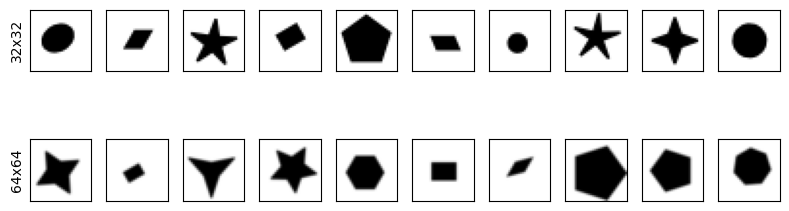

In [12]:
fig = plot_samples(samples32, samples64)
fig.get_axes()[0].set_ylabel("32x32")
fig.get_axes()[len(samples32)].set_ylabel("64x64")
fig.tight_layout()
fig

In [13]:
data = dict(Model=[], Run=[], Experiment=[], **{m: [] for m in METRICS})
for sname, versions in grouped_models.items():
    for idx, model in enumerate(versions):
        o32, _ = load_results(OUTPUT_PATH, model, "shapetastic_ni_32", "no_transform")
        o64, cfg = load_results(OUTPUT_PATH, model, "shapetastic_ni_64", "no_transform")
        model = instantiate(cfg.model).create(device=DEVICE)

        s32 = o32["Raw"]["item"]
        s64 = o64["Raw"]["item"]

        data["Model"].append(sname)
        data["Run"].append(idx)
        data["Experiment"].append("32x32")
        for k, v in compute_metrics_(model, s32).items():
            data[k].append(v)

        data["Model"].append(sname)
        data["Run"].append(idx)
        data["Experiment"].append("64x64")
        for k, v in compute_metrics_(model, s64, s32).items():
            data[k].append(v)

data = pd.DataFrame(data)
stats = (
    data.groupby(["Model", "Experiment"])
    .agg(["mean", "std"])[METRICS]
    .map("{:.3f}".format)
)
stats

AUROC         FPR95         maxAE          nMSE         \
                    mean    std   mean    std   mean    std   mean    std   
Model  Experiment                                                           
EBO    32x32       0.999  0.000  0.001  0.000  0.000  0.000  0.000  0.000   
       64x64       0.554  0.070  0.813  0.047  1.267  0.072  0.885  0.064   
HB     32x32       0.999  0.000  0.001  0.000  0.000  0.000  0.000  0.000   
       64x64       0.880  0.036  0.542  0.119  1.001  0.001  0.689  0.096   
HB-Vit 32x32       1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
       64x64       0.976  0.011  0.098  0.035  1.001  0.001  0.283  0.049   
POEM   32x32       0.998  0.002  0.000  0.000  0.000  0.000  0.000  0.000   
       64x64       0.685  0.064  0.652  0.086  1.515  0.094  0.661  0.080   

                     nWD         
                    mean    std  
Model  Experiment                
EBO    32x32       0.993  0.014  
       64x64       0.100  0.030  
HB     32x32       0.997  0.001  
       64x64       0.249  0.092  
HB-Vit 32x32       0.998  0.002  
       64x64       0.622  0.054  
POEM   32x32       0.968  0.045  
       64x64       0.235  0.069

In [14]:
# from itertools import repeat

# means = stats[zip(METRICS, repeat("mean"))].droplevel(1, axis=1)
# stds = stats[zip(METRICS, repeat("std"))].droplevel(1, axis=1)

# cc = "$" + means + "^{\pm " + stds + "}$"
# tex = cc.to_latex()

# tex = tex.replace(r"AUROC", r"\ac{auroc}")
# tex = tex.replace(r"FPR95", r"\ac{fpr95}")
# tex = tex.replace(r"nWD", r"\ac{nwd}")
# tex = tex.replace(r"MSE", r"\ac{nmse}")
# tex = tex.replace(r"maxAE", r"\ac{maxae}")

# tex = tex.replace(r"EBO", r"\ac{ebo}")
# tex = tex.replace(r"HB-ViT", r"\ac{hb-vit}")
# tex = tex.replace(r"HB", r"\ac{hb}")
# tex = tex.replace(r"POEM", r"\ac{poem}")

# tex = tex.replace(r"Raw", r"\emph{$32$x$32$}")
# tex = tex.replace(r"Resize", r"\emph{$64$x$64$}")

# tex = tex.replace(r"Experiment", r"Dataset")

# print(tex)

## Gaussian Blur

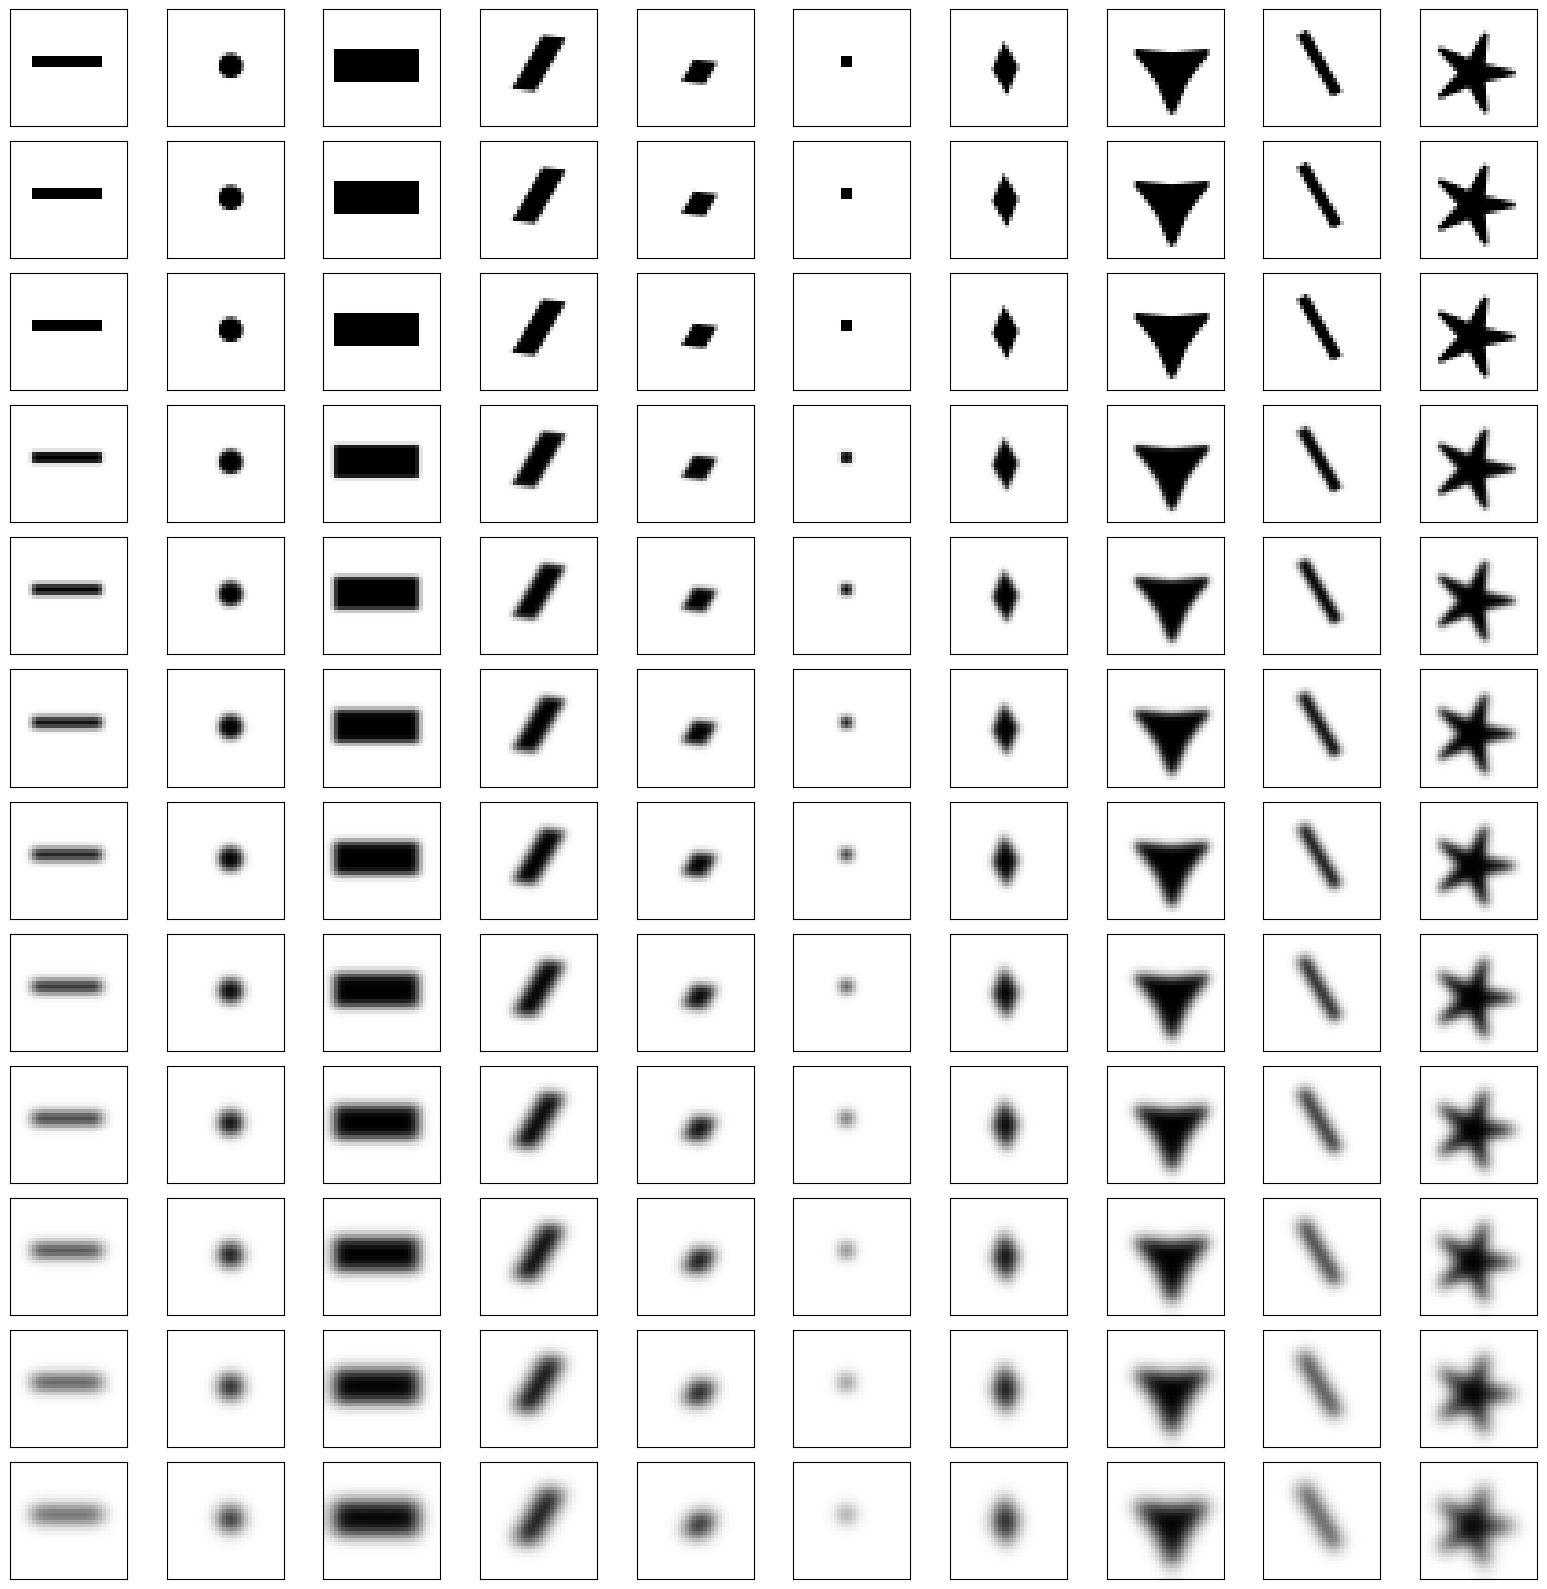

In [15]:
out, _ = load_results(OUTPUT_PATH, "ebo_model_v1", "shapetastic_ni_32", "gaussianblur")

samples = []
for ename, exp in out.items():
    samples.append(exp["transformed_image"])

MultiImagePlotter(
    sum(samples, []), layout=(len(samples), len(samples[0])), figsize=(16,16)
).plot()

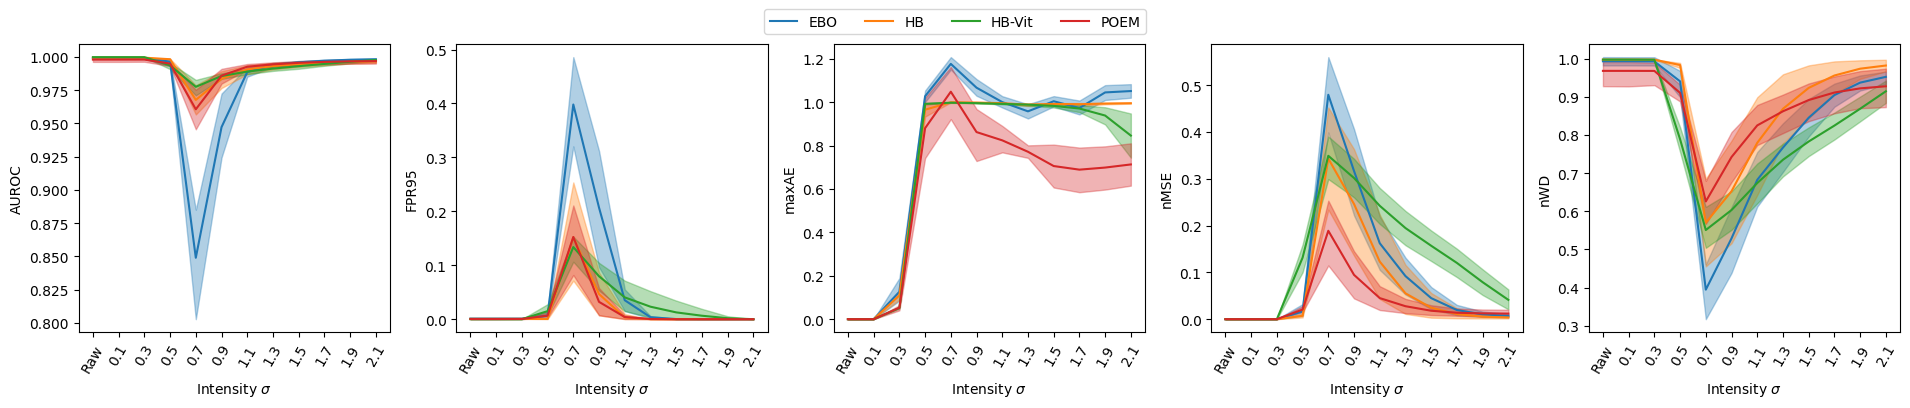

In [16]:
data = compute_metrics("shapetastic_ni_32", "gaussianblur")
plot_results(
    data,
    r"Intensity $\sigma$",
    [
        "Raw",
        "0.1",
        "0.3",
        "0.5",
        "0.7",
        "0.9",
        "1.1",
        "1.3",
        "1.5",
        "1.7",
        "1.9",
        "2.1",
    ],
)

## Hue Shift

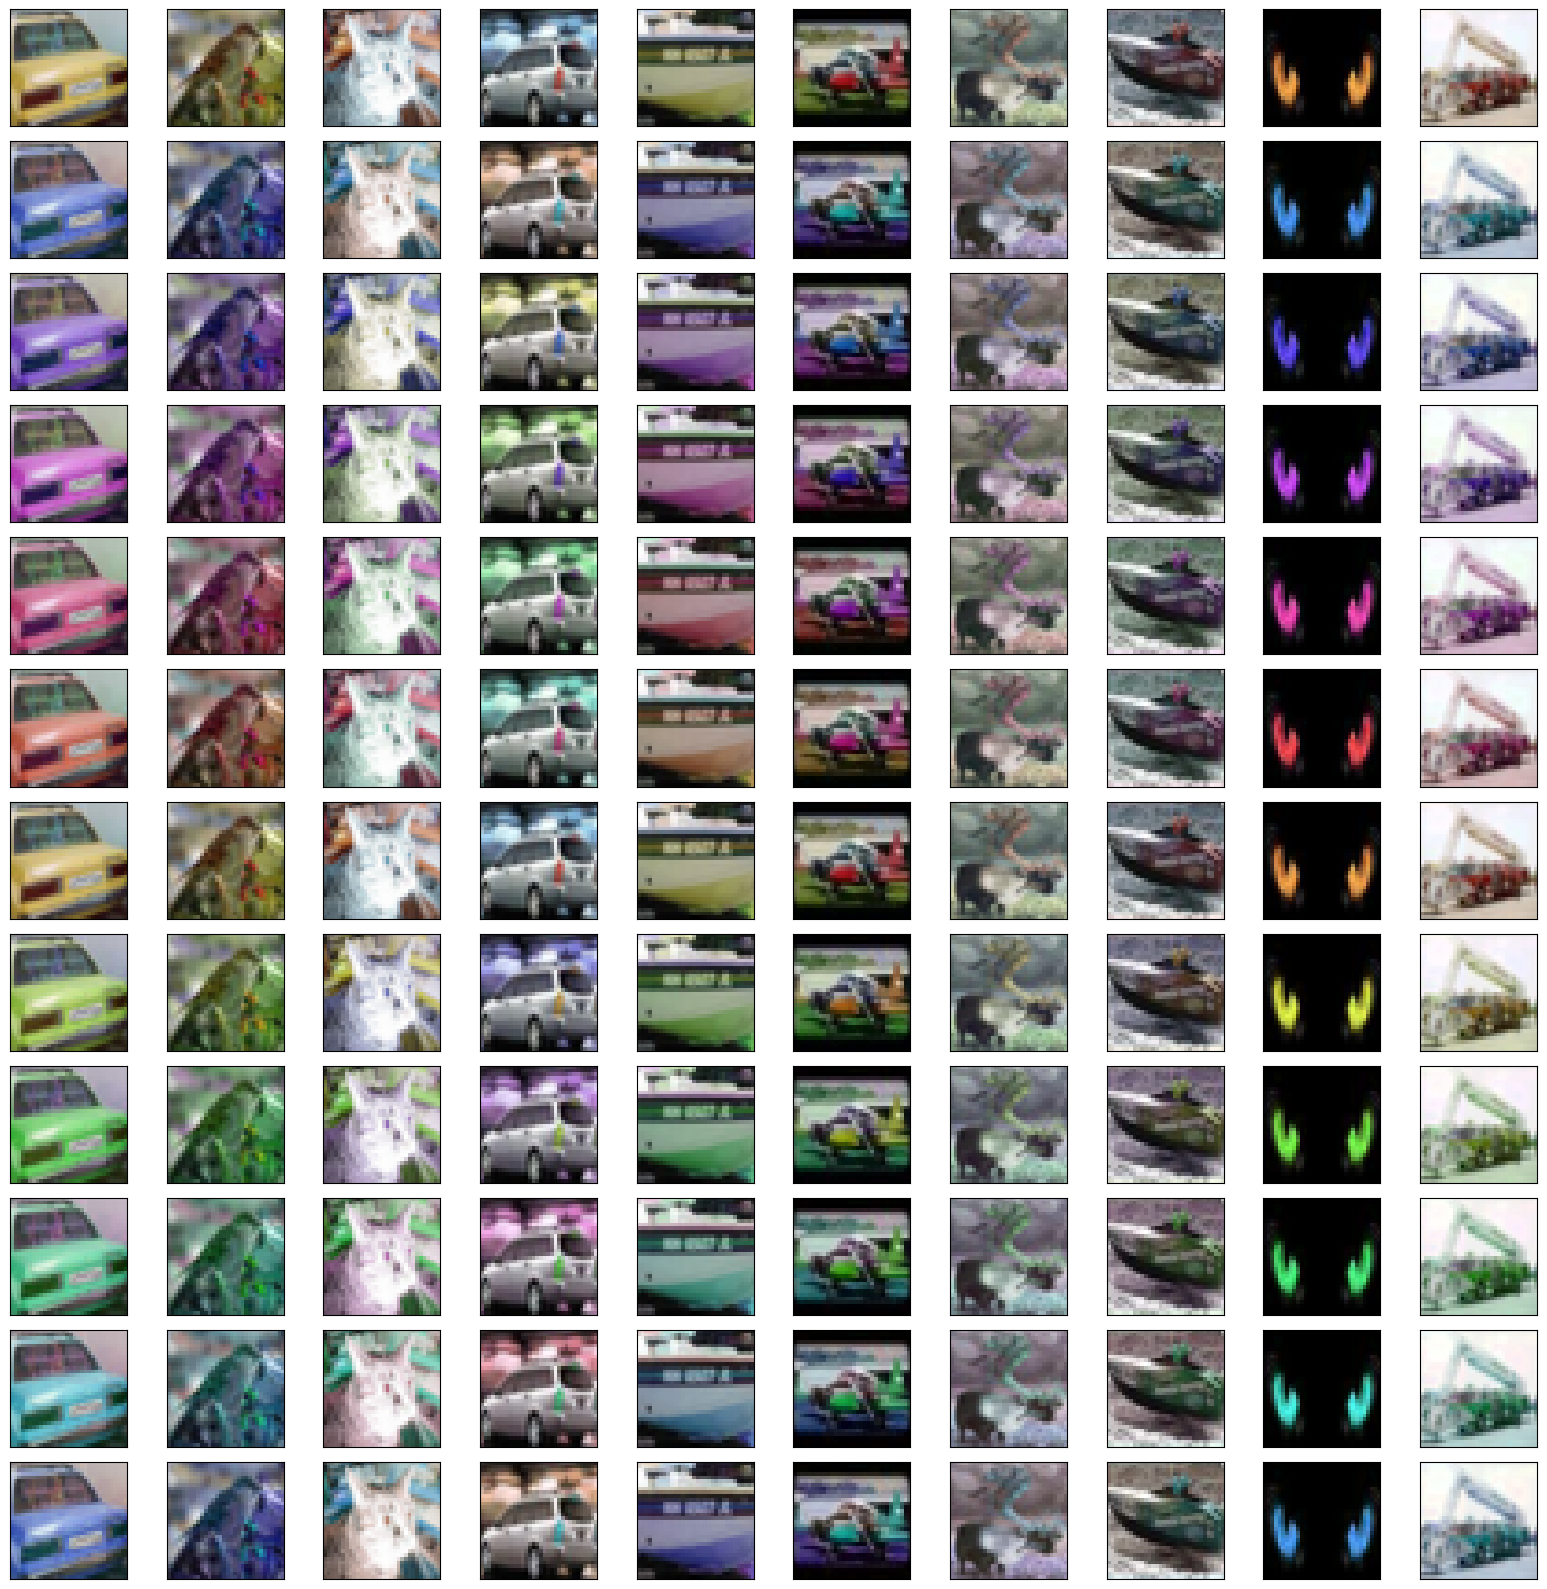

In [17]:
out, _ = load_results(OUTPUT_PATH, "ebo_model_v1", "cifar10", "hueshift")

samples = []
for ename, exp in out.items():
    samples.append(exp["transformed_image"])

MultiImagePlotter(
    sum(samples, []), layout=(len(samples), len(samples[0])), figsize=(16, 16)
).plot()

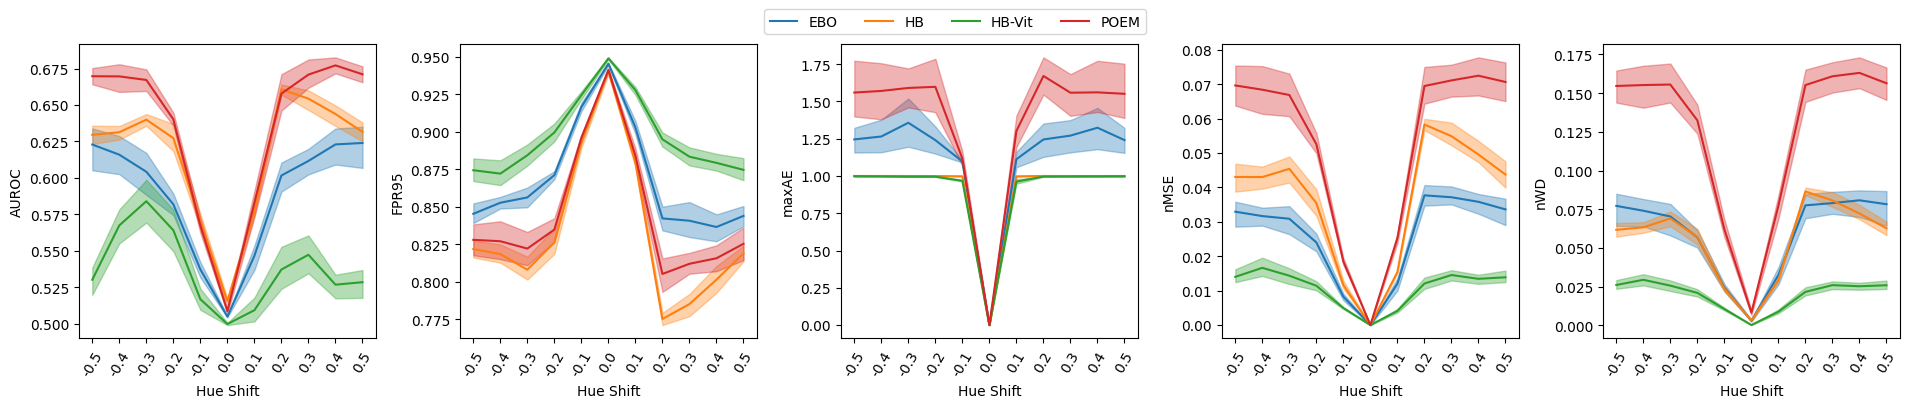

In [18]:
data = compute_metrics("cifar10", "hueshift", "Hue=0.00")
plot_results(
    data[data.Experiment != " Raw"],
    r"Hue Shift",
    [f"{v:.1f}" for v in np.linspace(-0.5, 0.5, 11, endpoint=True)],
)

## Compression - Shapetastic

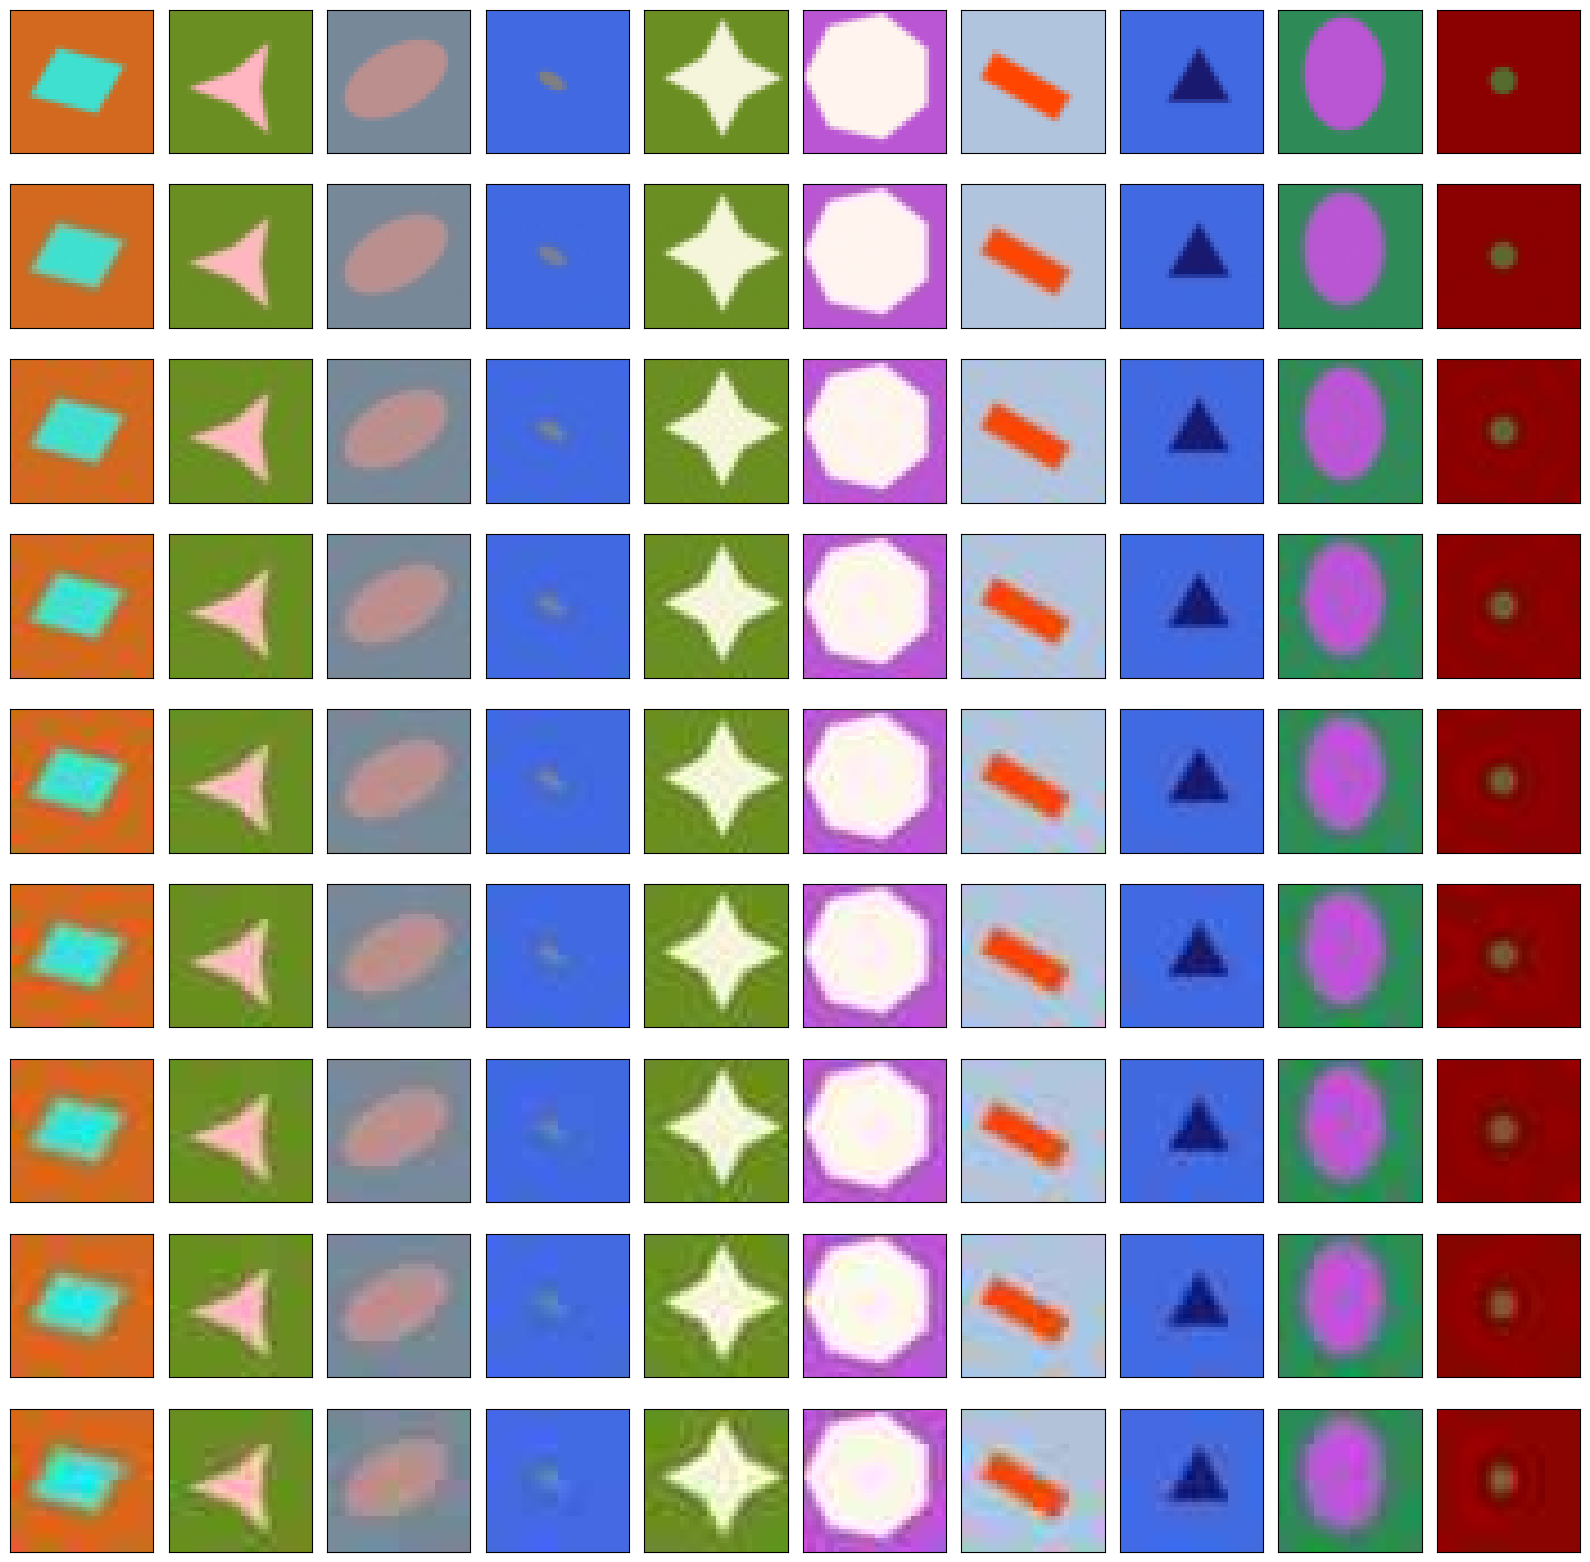

In [19]:
out, _ = load_results(
    OUTPUT_PATH, "ebo_model_v1", "shapetastic_cb_cs", "compression_jpeg"
)

samples = []
for ename, exp in out.items():
    samples.append(exp["transformed_image"])

MultiImagePlotter(
    sum(samples, []), layout=(len(samples), len(samples[0])), figsize=(16, 16)
).plot()

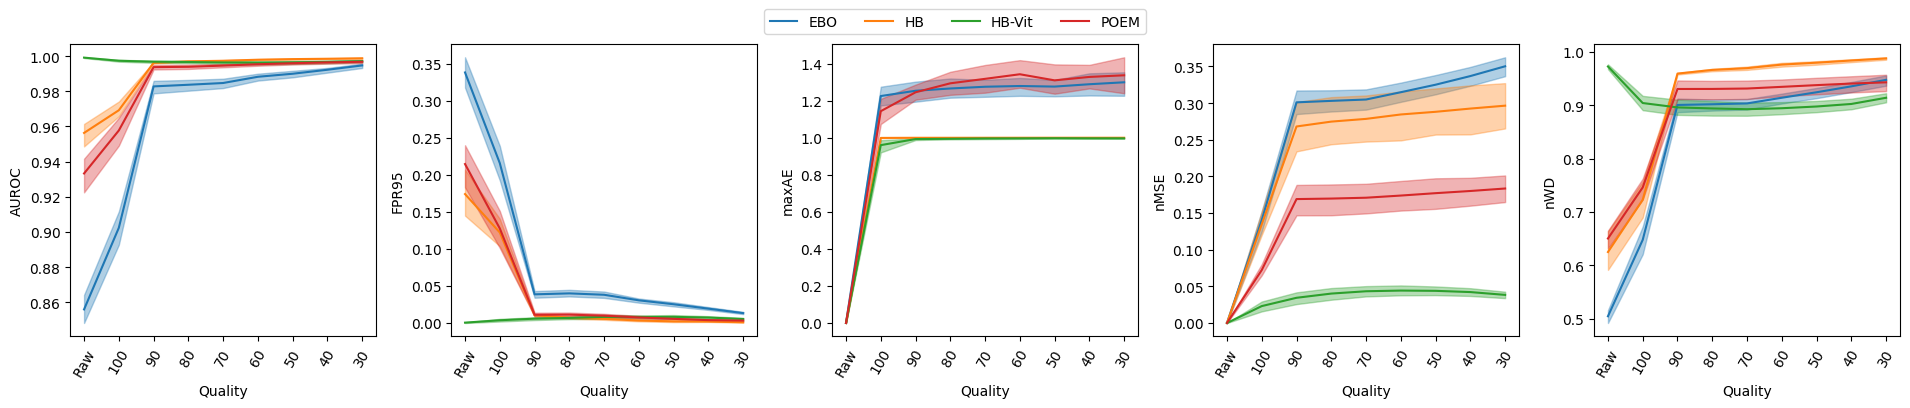

In [20]:
data = compute_metrics("shapetastic_cb_cs", "compression_jpeg")
plot_results(
    data,
    r"Quality",
    ["Raw", "100", "90", "80", "70", "60", "50", "40", "30"],
)

## Compression - CIFAR10

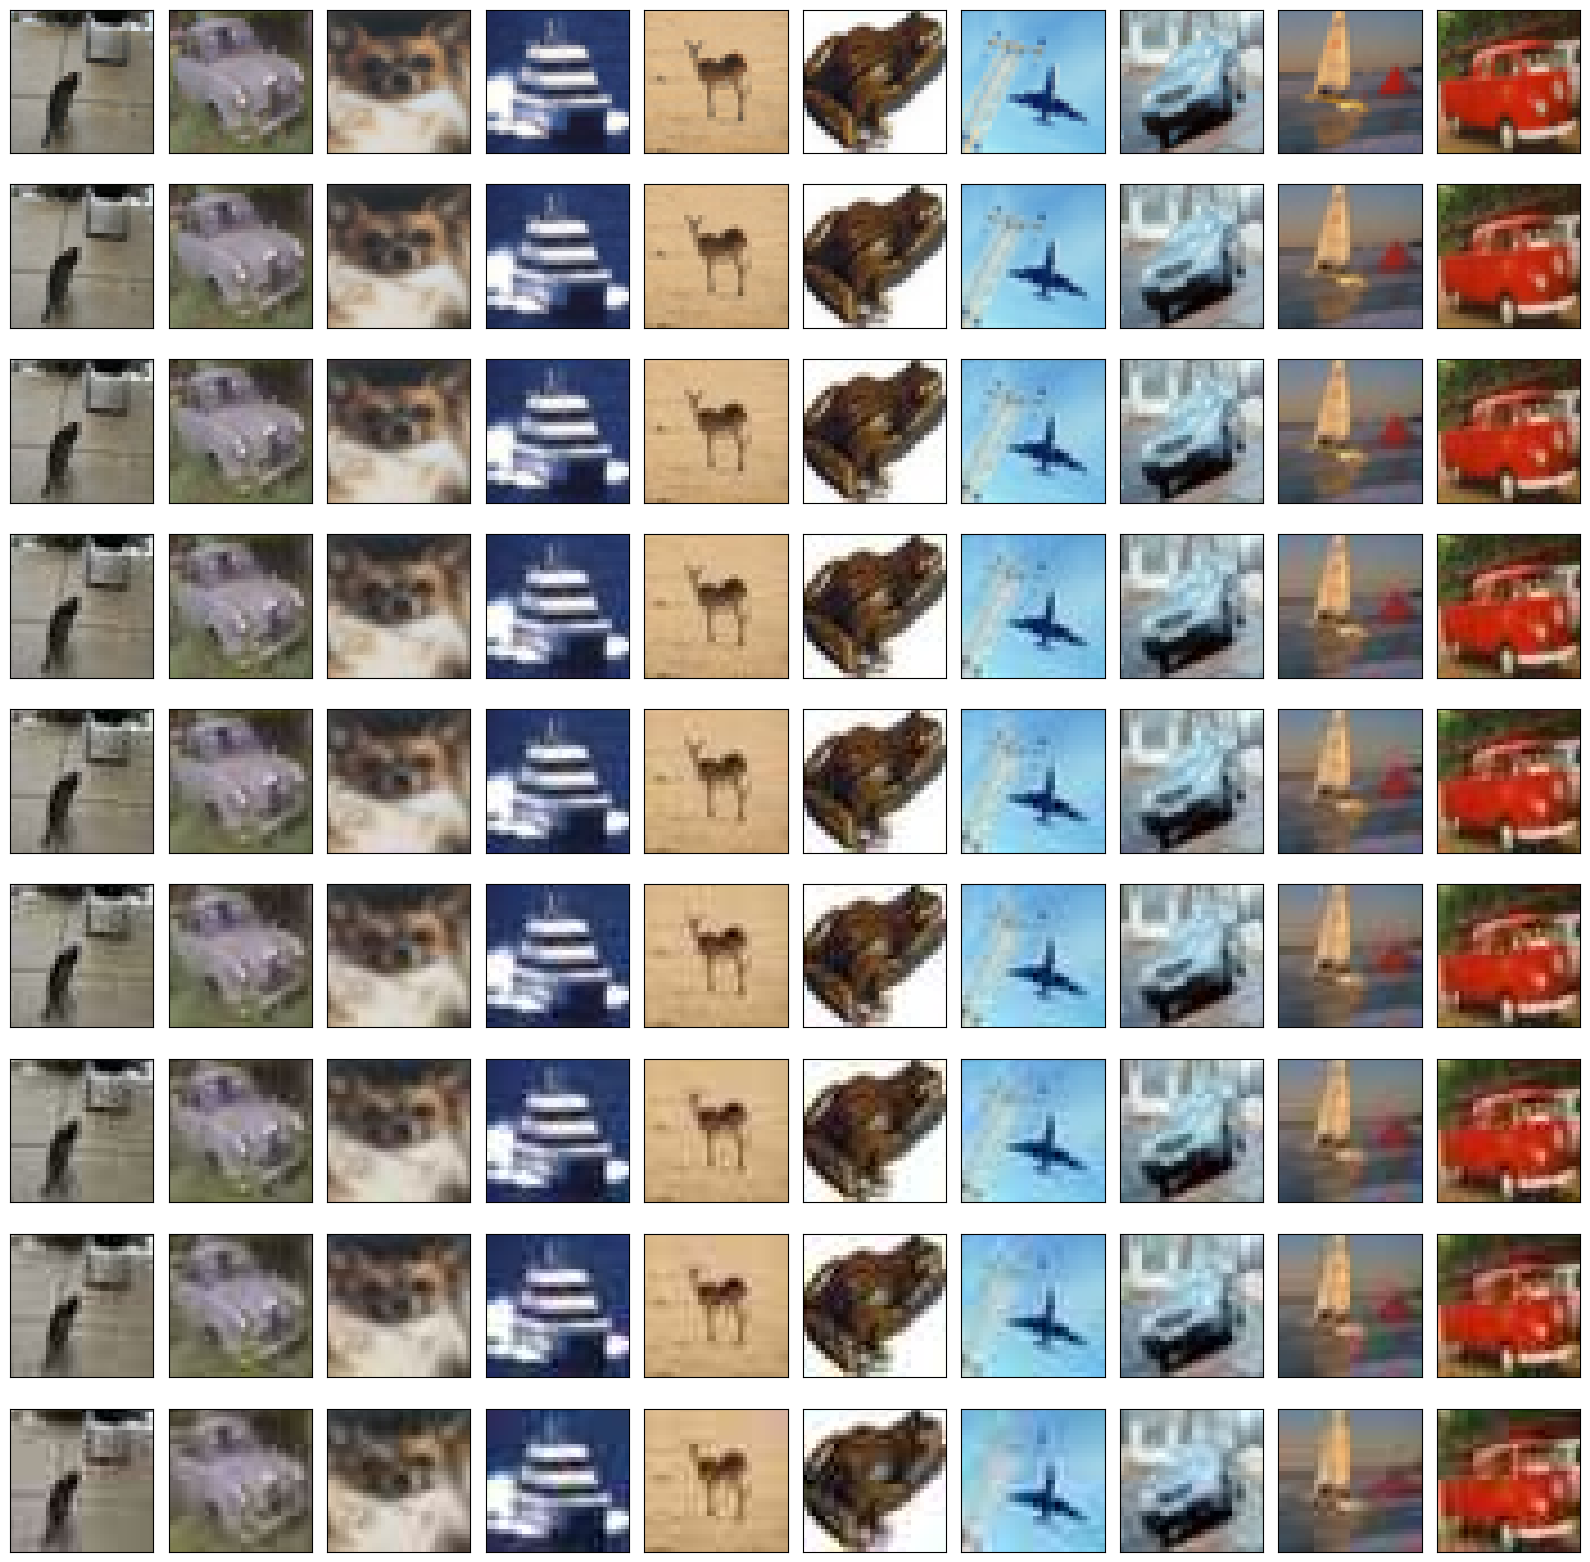

In [21]:
out, _ = load_results(OUTPUT_PATH, "ebo_model_v1", "cifar10", "compression_jpeg")

samples = []
for ename, exp in out.items():
    samples.append(exp["transformed_image"])

MultiImagePlotter(
    sum(samples, []), layout=(len(samples), len(samples[0])), figsize=(16, 16)
).plot()

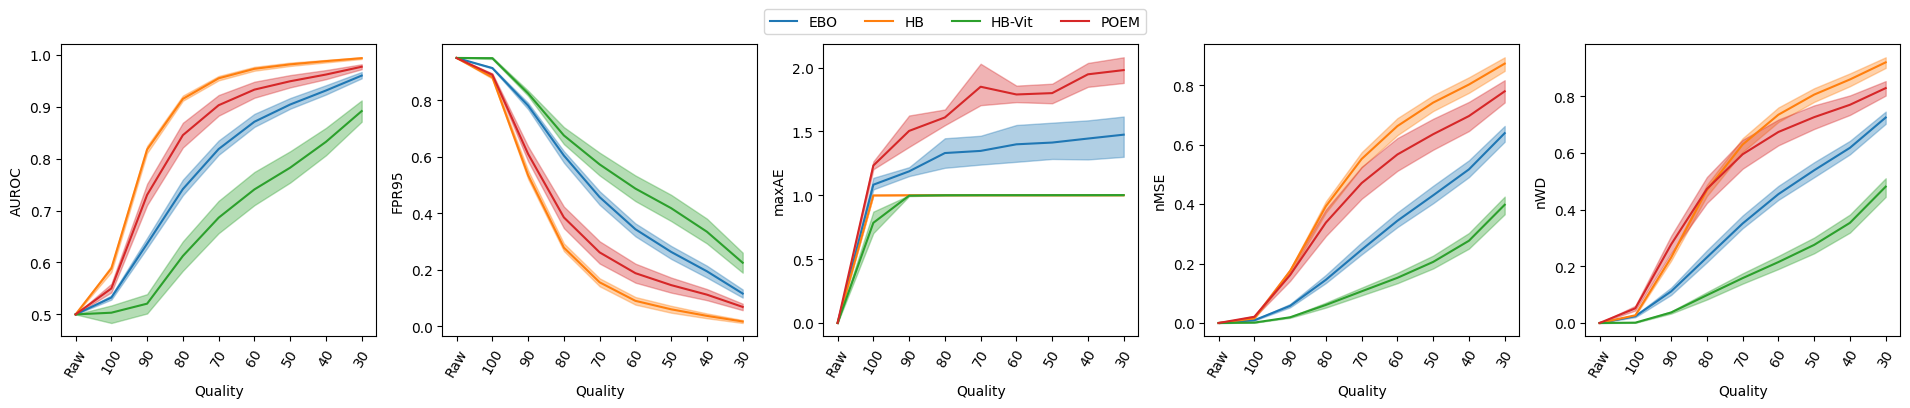

In [22]:
data = compute_metrics("cifar10", "compression_jpeg")
plot_results(
    data,
    r"Quality",
    ["Raw", "100", "90", "80", "70", "60", "50", "40", "30"],
)

## Compression - ImageNet

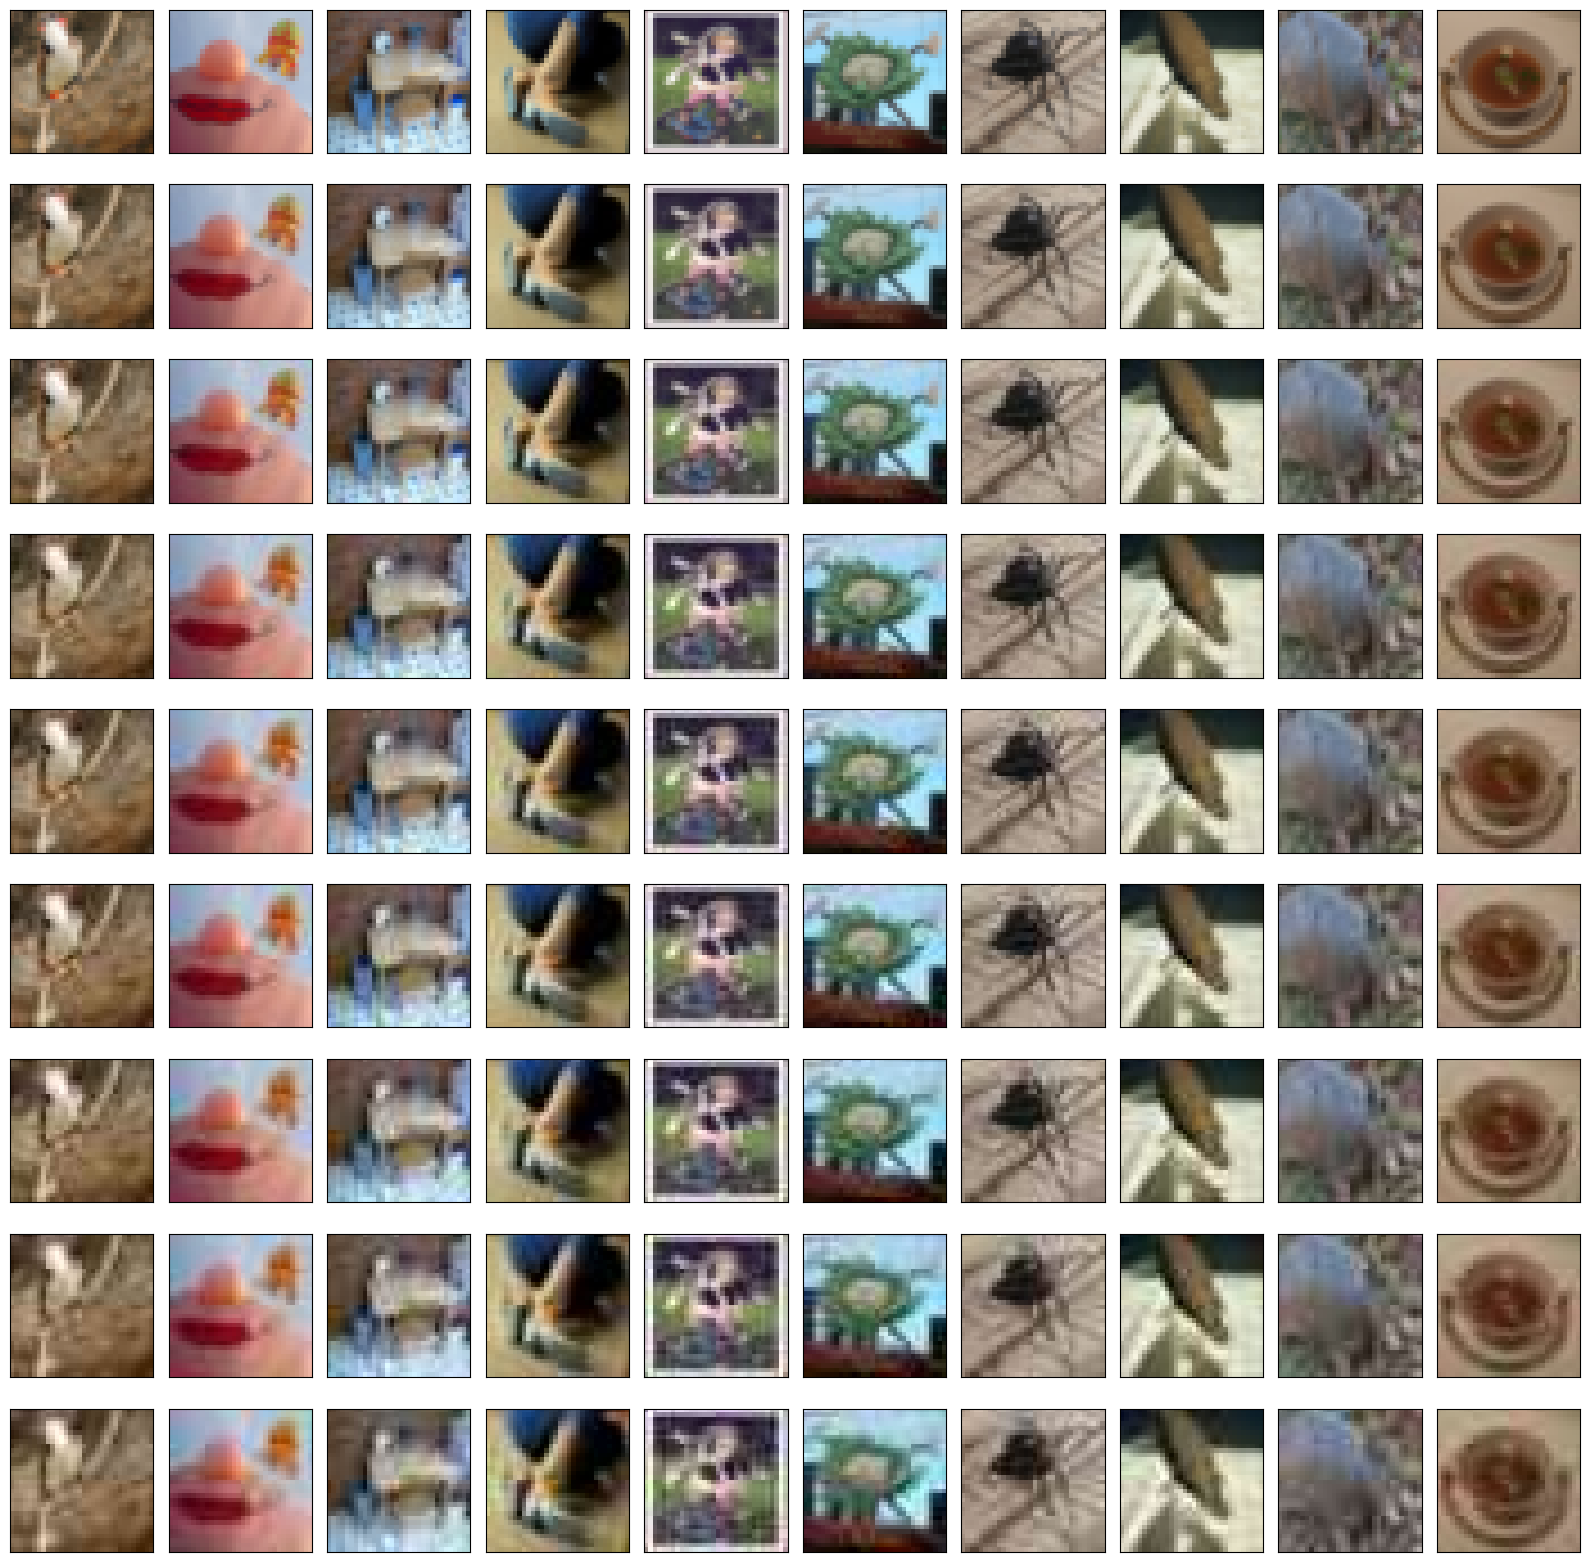

In [23]:
out, _ = load_results(OUTPUT_PATH, "ebo_model_v1", "imagenet", "compression_jpeg")

samples = []
for ename, exp in out.items():
    samples.append(exp["transformed_image"])

MultiImagePlotter(
    sum(samples, []), layout=(len(samples), len(samples[0])), figsize=(16, 16)
).plot()

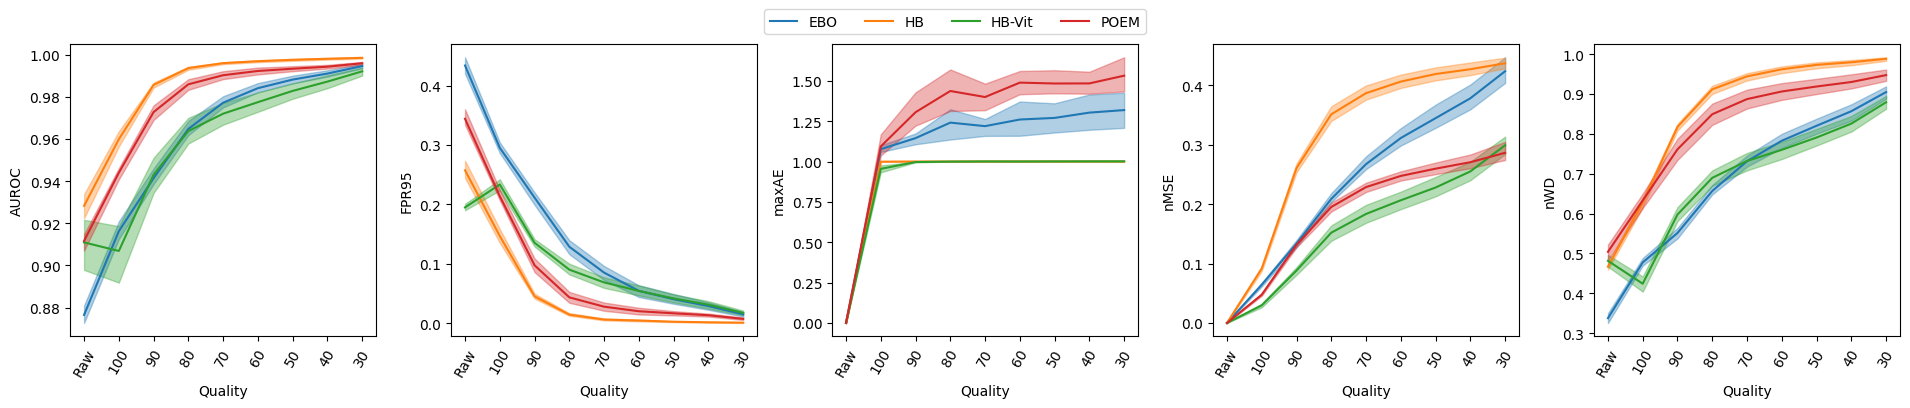

In [24]:
data = compute_metrics("imagenet", "compression_jpeg")
plot_results(
    data,
    r"Quality",
    ["Raw", "100", "90", "80", "70", "60", "50", "40", "30"],
)

## Rotate

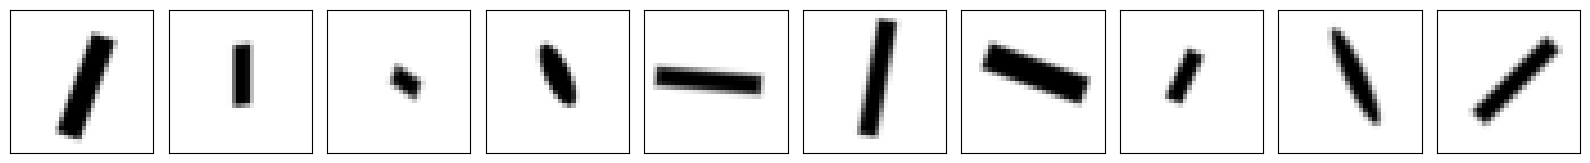

In [25]:
out, cfg = load_results(
    OUTPUT_PATH, "ebo_model_v1", "shapetastic_gs_rot", "no_transform"
)

samples = []
for ename, exp in out.items():
    samples.append(exp["transformed_image"])

MultiImagePlotter(
    sum(samples, []), layout=(len(samples), len(samples[0])), figsize=(16, 16)
).plot()

In [26]:
dpath = instantiate(cfg.dataset.root)
meta_df = read_csv_data_frames(dpath.glob("*.csv"))
meta_df

x     y  width  height  color  rotation_angle      outline  \
0      0.55  0.53   0.39    0.20  black             5.0  interpolate   
1      0.48  0.55   0.90    0.19  black           145.0  interpolate   
2      0.46  0.46   0.73    0.14  black            35.0  interpolate   
3      0.45  0.47   0.64    0.17  black           140.0  interpolate   
4      0.53  0.46   0.81    0.16  black             0.0  interpolate   
...     ...   ...    ...     ...    ...             ...          ...   
19995  0.48  0.47   0.39    0.13  black            75.0  interpolate   
19996  0.49  0.46   0.90    0.16  black           115.0  interpolate   
19997  0.49  0.47   0.47    0.10  black            85.0  interpolate   
19998  0.52  0.48   0.64    0.10  black           130.0  interpolate   
19999  0.48  0.51   0.56    0.10  black           130.0  interpolate   

       linewidth  image_width  image_height background_color   plot_function  \
0              3          200           200            white    draw_ellipse   
1              1          200           200            white    draw_ellipse   
2              1          200           200            white    draw_ellipse   
3              3          200           200            white    draw_ellipse   
4              2          200           200            white    draw_ellipse   
...          ...          ...           ...              ...             ...   
19995          1          200           200            white  draw_rectangle   
19996          1          200           200            white  draw_rectangle   
19997          3          200           200            white  draw_rectangle   
19998          1          200           200            white  draw_rectangle   
19999          3          200           200            white  draw_rectangle   

       file_name  skew  
0          0.png   NaN  
1          1.png   NaN  
2          2.png   NaN  
3          3.png   NaN  
4          4.png   NaN  
...          ...   ...  
19995  19995.png   NaN  
19996  19996.png   NaN  
19997  19997.png   NaN  
19998  19998.png   NaN  
19999  19999.png   NaN  

[60000 rows x 14 columns]

In [27]:
group_indices = group_idx(out["Raw"]["file"], meta_df, "rotation_angle")

metrics = []
for d, idxs in group_indices.items():
    mets = compute_metrics(
        "shapetastic_gs_rot", "no_transform", "Raw", idxs
    )
    mets["Angle"] = [d] * len(mets)
    metrics.append(mets)

metrics = pd.concat(metrics)

EBO
FPR95


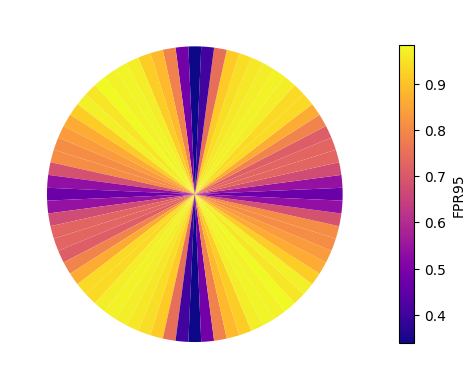

nWD


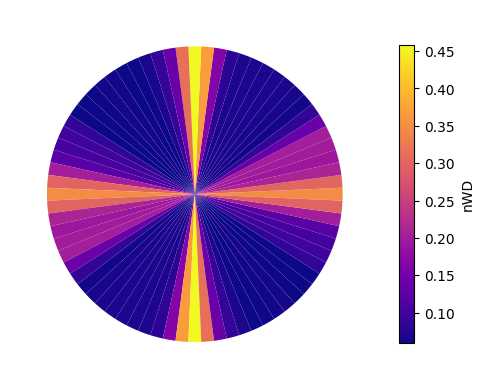

HB
FPR95


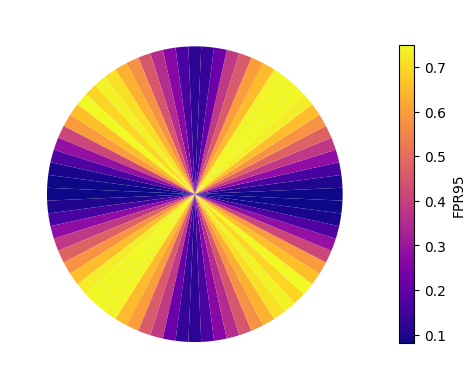

nWD


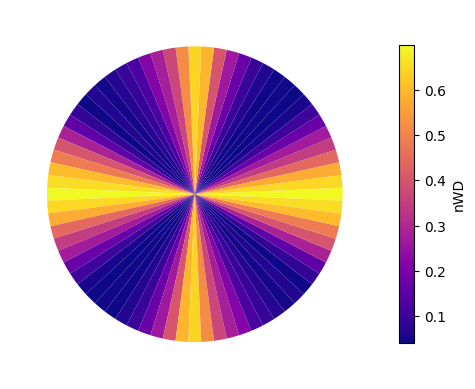

HB-Vit
FPR95


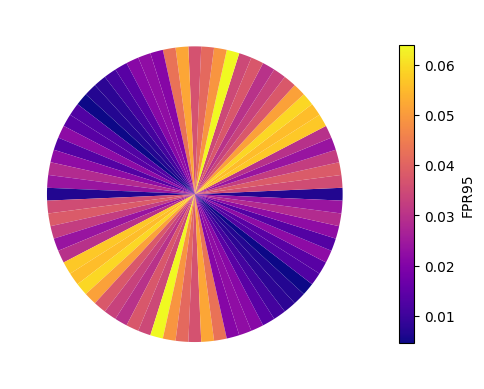

nWD


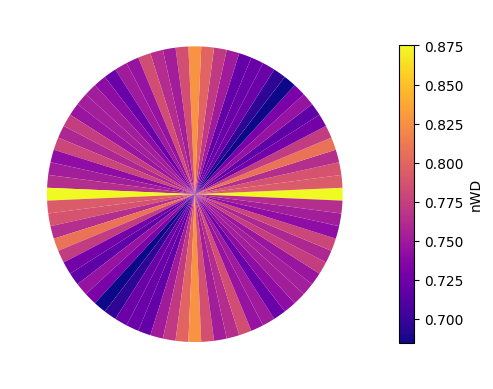

POEM
FPR95


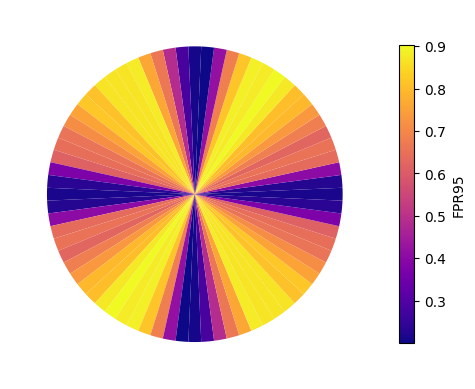

nWD


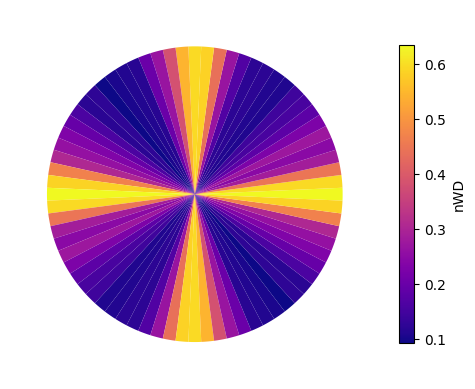

In [28]:
metrs = (
    metrics
    .groupby(["Model", "Angle"])[["AUROC", "FPR95", "nWD"]]
    .mean()
)
metrs.reset_index(level=1, inplace=True)
metrs.reset_index(level=0, inplace=True)

for model in grouped_models.keys():
    print(model)
    for met in ["FPR95", "nWD"]:
        print(met)
        data = (
            metrs[(metrs.Model == model)]
            .sort_values(["Angle"])[met]
            .to_numpy()
        )
        data = np.hstack([data, data])
        fig = plot_pie_chart(data, label=met, startangle=-2.5)
        display(fig)